In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
import numpy as np

In [2]:
df = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/final_gpu_time_windows.parquet")
df.groupby(["app_name", "label"]).size()
df.head()

,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json,app_name,label,experiment_time
0,64666,hashcat,0,0,0,0,0,0,,,...,4.0,0.0,2025-11-11 22:31:33.200000+00:00,1762900293200,,,{},passwd_hashcat,1,20251111T222850Z
1,64666,hashcat,0,0,0,0,0,0,,,...,0.0,0.0,2025-11-11 22:31:36.994000+00:00,1762900296994,,,{},passwd_hashcat,1,20251111T222850Z
2,64417,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:41.469000+00:00,1762900121469,,,{},passwd_hashcat,1,20251111T222850Z
3,64443,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:45.610000+00:00,1762900125610,,,{},passwd_hashcat,1,20251111T222850Z
4,64469,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:48.582000+00:00,1762900128582,,,{},passwd_hashcat,1,20251111T222850Z


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   pid                     2946 non-null   uint32             
 1   comm                    2946 non-null   object             
 2   uid                     2946 non-null   uint32             
 3   gid                     2946 non-null   uint32             
 4   ppid                    2946 non-null   uint32             
 5   user_pid                2946 non-null   uint32             
 6   user_ppid               2946 non-null   uint32             
 7   cgroup_id               2946 non-null   uint64             
 8   cgroup_name             2946 non-null   object             
 9   user                    2946 non-null   object             
 10  window_start_ns         2946 non-null   int64              
 11  window_end_ns           2946 non-null   int

In [4]:
df.isna().sum()

pid                       0
comm                      0
uid                       0
gid                       0
ppid                      0
user_pid                  0
user_ppid                 0
cgroup_id                 0
cgroup_name               0
user                      0
window_start_ns           0
window_end_ns             0
kernel_launch_count       0
mem_alloc_count           0
memcpy_count              0
stream_sync_count         0
avg_threads_per_kernel    0
max_threads_per_kernel    0
avg_blocks_per_kernel     0
total_threads_launched    0
total_mem_alloc_bytes     0
avg_mem_alloc_bytes       0
total_memcpy_bytes        0
avg_memcpy_bytes          0
htod_bytes                0
dtoh_bytes                0
htod_ratio                0
avg_sync_time_ns          0
max_sync_time_ns          0
sync_fraction             0
launch_rate               0
memcpy_rate               0
alloc_rate                0
wall_time_dt              0
wall_time_ms              0
container_id        

In [5]:
counts = df["label"].value_counts()
print(counts)

# Or more descriptive:
print("Benign (0):", counts.get(0, 0))
print("Malign (1):", counts.get(1, 0))
print("Total:", len(df))

label
0    1811
1    1135
Name: count, dtype: int64
Benign (0): 1811
Malign (1): 1135
Total: 2946


In [6]:
counts = df["app_name"].value_counts()
print(counts)

app_name
llm_gpt_neo       754
miner_xmrig       679
passwd_hashcat    456
ml_svm            241
llm_gpt           190
llm_bert          132
dl_lstm_train     131
dl_cnn_train      109
blender            98
llm_roberta        85
ml_logreg          46
ml_forest          25
Name: count, dtype: int64


In [7]:
df["experiment_id"] = df["app_name"].astype(str) + "_" + df["experiment_time"].astype(str)

In [8]:
drop_cols = [
    "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
    "cgroup_id", "cgroup_name", "user",
    "container_id", "container_image", "container_labels_json",
    "experiment_time", "wall_time_dt", "wall_time_ms", "window_start_ns", "window_end_ns"
]
df = df.drop(columns=drop_cols, errors="ignore")


In [9]:
X = df.drop(columns=["label", "app_name", "comm", "experiment_id", "label"])
y = df["label"]
groups = df["experiment_id"]

In [10]:
scaler = StandardScaler()
num_cols = X.select_dtypes(include=["float64", "int64", "uint64", "uint32"]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

In [12]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 2475
Test size : 471


In [13]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # two hidden layers
    activation="relu",
    solver="adam",
    alpha=0.0005,                  # L2 regularization
    learning_rate="adaptive",
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp.fit(X_train, y_train)

,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0005
,batch_size,'auto'
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [14]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

acc = mlp.score(X_test, y_test)
auc = roc_auc_score(y_test, y_prob)

print("\n=== MLP NEURAL NETWORK RESULTS ===")
print(f"Accuracy : {acc:.4f}")
print(f"AUC      : {auc:.4f}")
print(classification_report(y_test, y_pred))



=== MLP NEURAL NETWORK RESULTS ===
Accuracy : 0.9851
AUC      : 0.9971
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       392
           1       0.97      0.94      0.95        79

    accuracy                           0.99       471
   macro avg       0.98      0.97      0.97       471
weighted avg       0.99      0.99      0.99       471



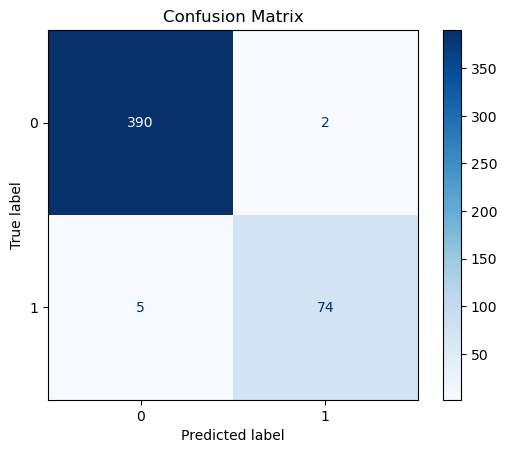

In [15]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

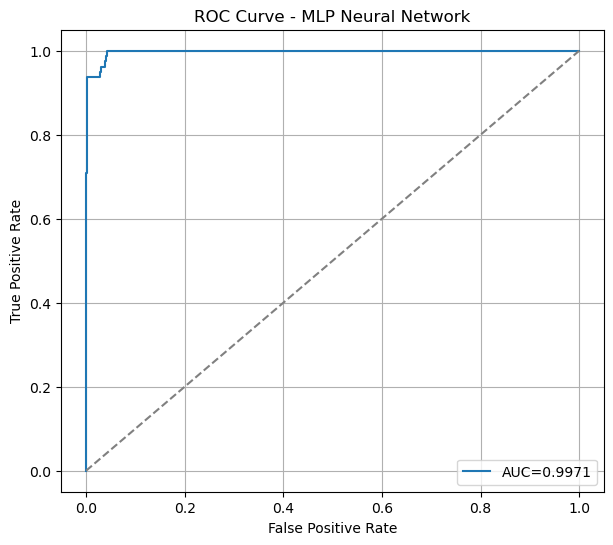

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP Neural Network")
plt.legend()
plt.grid(True)
plt.show()

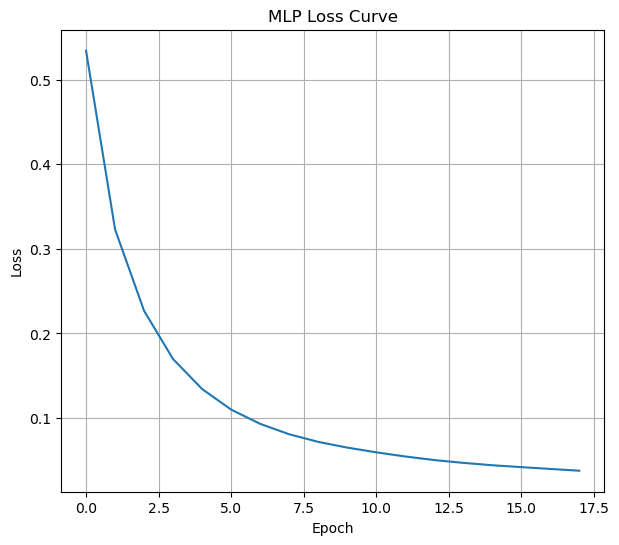

In [17]:
plt.figure(figsize=(7, 6))
plt.plot(mlp.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [18]:
def evaluate_dataset_mlp(df_test, mlp, train_features, label_for_dataset, num_cols=num_cols):
    # Drop metadata columns
    df_test_clean = df_test.drop(columns=drop_cols, errors="ignore")
    
    # Align features
    df_test_clean = df_test_clean[train_features]

    # Apply the same scaler used during training
    df_test_clean[num_cols] = scaler.transform(df_test_clean[num_cols])

    # Predictions
    y_pred = mlp.predict(df_test_clean)
    y_prob = mlp.predict_proba(df_test_clean)[:, 1]

    # Ground truth labels
    y_true = np.full(len(y_pred), label_for_dataset)

    print(y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Handle case where only one class exists
    if cm.size == 1:
        if label_for_dataset == 0:  # only benign
            tn, fp = cm[0][0], 0
            fn, tp = 0, 0
        else:                       # only malign
            tp, fn = cm[0][0], 0
            tn, fp = 0, 0
    else:
        tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)

    print("\n==============================")
    print("     MLP CLASSIFIER EVALUATION")
    print("==============================")
    print(f"Dataset label            : {label_for_dataset}  "
          f"({'benign' if label_for_dataset==0 else 'malign'})")
    print(f"Samples                  : {len(y_pred)}")
    print(f"Accuracy                 : {accuracy:.4f}")
    print(f"Predicted positives      : {y_pred.sum()}")
    print(f"Predicted negatives      : {(y_pred==0).sum()}")

    print("\nConfusion Matrix:")
    print(f"TN={tn}   FP={fp}")
    print(f"FN={fn}   TP={tp}")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "accuracy": accuracy,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }

In [19]:
df_malign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/lolminer/audit_gpu_time_window_events.parquet"
)

results_malign_mlp = evaluate_dataset_mlp(
    df_test=df_malign,
    mlp=mlp,
    train_features=X_train.columns,
    label_for_dataset=1
)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]

     MLP CLASSIFIER EVALUATION
Dataset label            : 1  (malign)
Samples                  : 45
Accuracy                 : 1.0000
Predicted positives      : 45
Predicted negatives      : 0

Confusion Matrix:
TN=0   FP=0
FN=0   TP=45


In [20]:
df_benign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/llm_blom/audit_gpu_time_window_events.parquet"
)

results_benign_mlp = evaluate_dataset_mlp(
    df_test=df_benign,
    mlp=mlp,
    train_features=X_train.columns,
    label_for_dataset=0
)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]

     MLP CLASSIFIER EVALUATION
Dataset label            : 0  (benign)
Samples                  : 79
Accuracy                 : 1.0000
Predicted positives      : 0
Predicted negatives      : 79

Confusion Matrix:
TN=79   FP=0
FN=0   TP=0
